In [1]:
#!/usr/bin/env python

import os, sys, csv, json
import networkx as nx
import pygraphviz as pygv
from IPython.display import Image, display

# Import javalang from local directory
sys.path.append("./")
import javalang

## 1. Project selection

### _Configuration!_

Set the project to be analyzed in the _project_ variable

Set to **True** the _read_from_file_ variable to read from an existing exclusions file.\
If the the refinement file need to be updated or created, set to **True** the _update_refinement_ variable

In [2]:
# CONFIGURATION:

project = 'jpetstore' # <-- Set this variable!

read_from_file = True # <-- Set this variable!
update_refinement = False  # <-- Set this variable!
headless = False

In [3]:
# Parameters
project = "springblog"
read_from_file = True
update_refinement = False
headless = True


In [4]:
with open('projects.json', 'r') as projects:
    project_found = False
    for data in json.load(projects):
        if data['name'] == project:
            source_basedir = data['source_basedir']
            analysis_results_basedir = data['analysis_results_basedir']
            project_found = True
    if not project_found:
        print('ERROR: project ' + project + ' does not appear in project.json')

In [5]:
# Extract all the Java files from the project direcotry
avoid_directories = ['.git', '.ipynb_checkpoints', 'test', 'resources']
avoid_files = ['package-info.java']

java_files = []

for dirname, dirnames, filenames in os.walk(source_basedir):
    for avoid_dir in avoid_directories:
        if avoid_dir in dirnames:
            # don't go into any .git directories.
            dirnames.remove(avoid_dir)
    # print path to all filenames.
    for filename in filenames:
        if filename.endswith('.java') and filename not in avoid_files:
            java_files.append(os.path.join(dirname, filename))

if not java_files:
    print('ERROR: no Java files found in selected path')

## 2. Project scan

Classes will be listed in order to preview their inferred role in the application (if entity, if from the logic/controller layer, if from the repository layer)

In [6]:
# Build nodes.csv file for the project (need for cleaning?)
exclude_annotations = ['Configuration', 'SpringBootApplication', 'Aspect', 'ControllerAdvice'] # List of annotations to exclude
logic_annotations = ['Service', 'Component', 'Controller', 'RestController', 'Path'] # List of annotations for logic classes
repository_annotations = ['Repository']

compilation_units = []

for file in java_files:
    with open(file, 'r') as javafile:
        try:
            tree = javalang.parse.parse(javafile.read())
            compilation_units.append(tree)
        except Exception as e:
            print("ERROR: Exception {} raised while parsing {}: {} ".format(type(e), file, e))


for tree in compilation_units:
    for decl in tree.types:
        # Go through all classes in order to list them
        if isinstance(decl, javalang.tree.ClassDeclaration):
            if any(annotation in logic_annotations for annotation in map(lambda a: a.name, decl.annotations)):
                # If the class annotations are listed in logic_annotations consider the class as logic
                print('Logic\t\t' + decl.name + '\t\t' + tree.package.name)

            elif any(annotation in repository_annotations for annotation in map(lambda a: a.name, decl.annotations)):
                # If the class annotations are listed in repository_annotations consider the class as repository
                print('Repository\t\t' + decl.name + '\t\t' + tree.package.name)
            
            elif not any(annotation in exclude_annotations for annotation in map(lambda a: a.name, decl.annotations)):
                # If annotations are not listed as logic (from the if guard) AND there are no annotations that have to be excluded consider as entities
                print('Entity\t\t' + decl.name + '\t\t' + tree.package.name)

            else:
                # If annotations are excluded:
                print('Excluded\t' + decl.name + '\t\t' + tree.package.name)

        elif isinstance(decl, javalang.tree.InterfaceDeclaration):
            # List interfaces
            print('Interface\t' + decl.name + '\t\t' + tree.package.name)

Excluded	CacheConfiguration		com.raysmond.blog
Excluded	SecurityConfig		com.raysmond.blog
Excluded	SpringBlogApplication		com.raysmond.blog
Excluded	WebConfig		com.raysmond.blog
Entity		Constants		com.raysmond.blog
Entity		UserForm		com.raysmond.blog.forms
Entity		PostForm		com.raysmond.blog.forms
Entity		SettingsForm		com.raysmond.blog.forms
Entity		Message		com.raysmond.blog.support.web
Entity		PygmentsVerbatimSerializer		com.raysmond.blog.support.web
Logic		PygmentsService		com.raysmond.blog.support.web
Logic		ViewHelper		com.raysmond.blog.support.web
Interface	SyntaxHighlightService		com.raysmond.blog.support.web
Interface	MarkdownService		com.raysmond.blog.support.web
Entity		MessageHelper		com.raysmond.blog.support.web
Logic		FlexmarkMarkdownService		com.raysmond.blog.support.web.impl
Logic		PegDownMarkdownService		com.raysmond.blog.support.web.impl
Interface	SettingRepository		com.raysmond.blog.repositories
Interface	PostRepository		com.raysmond.blog.repositories
Interface	TagRe

## 3. Layer refinement

### _User input required!_

#### List
- Packages and Classes to be excluded
- Entities, Logic and Repository Classes or Packages that have not been automatically listed as entities, logic and repository classes
- Interface of the repository layer that rely on Spring Data JPA framework, thus not having an implementing class (if needed)

#### Otherwise
Set to **True** the read_from_file variable to read from an existing refinement file.\
If the refinement file needs to be updated or created, set to **True** the update_refinement variable

In [7]:
# Set those variable if needed

# Exclude packages
# Exclude classes
# Force entity packages
# Force entity classes
# Force logic packages
# Force logic classes
# Force repository packages
# Force repository classes
# Force repository interfaces

exclude_packages = []
exclude_classes = []

force_entity_packages = []
force_entity_classes = []

force_logic_packages = []
force_logic_classes = []

force_repository_packages = []
force_repository_classes = []

force_repository_interface_package = []
force_repository_interface_class = []

In [8]:
if update_refinement:
    with open(analysis_results_basedir + project + '_refinement.json', 'w') as refinement_file:
        data = dict()
        data['exclude_packages'] = exclude_packages
        data['exclude_classes'] = exclude_classes
        data['force_entity_packages'] = force_entity_packages
        data['force_entity_classes'] = force_entity_classes
        data['force_logic_packages'] = force_logic_packages
        data['force_logic_classes'] = force_logic_classes
        data['force_repository_packages'] = force_repository_packages
        data['force_repository_classes'] = force_repository_classes
        data['force_repository_interface_package'] = force_repository_interface_package
        data['force_repository_interface_class'] = force_repository_interface_class
        json.dump(data, exclusions_file)

if read_from_file:
    with open(analysis_results_basedir + project + '_refinement.json', 'r') as refinement_file:
        refinement = json.load(refinement_file)
        exclude_packages = refinement['exclude_packages']
        exclude_classes = refinement['exclude_classes']
        force_entity_packages = refinement['force_entity_packages']
        force_entity_classes = refinement['force_entity_classes']
        force_logic_packages = refinement['force_logic_packages']
        force_logic_classes = refinement['force_logic_classes']
        force_repository_packages = refinement['force_repository_packages']
        force_repository_classes = refinement['force_repository_classes']
        force_repository_interface_package = refinement['force_repository_interface_package']
        force_repository_interface_class = refinement['force_repository_interface_class']

In [9]:
logic_classes = []
entity_classes = []
repository_classes = []
repository_interfaces = []
excluded_classes = []
interfaces = []

for tree in compilation_units:
    for decl in tree.types:
        # If it is a class declaration...
        if isinstance(decl, javalang.tree.ClassDeclaration):

            # If considered logic...
            if any(annotation in logic_annotations for annotation in map(lambda a: a.name, decl.annotations)):

                # and not in excluded packages and classes:
                if (decl.name not in exclude_classes and tree.package.name not in exclude_packages):

                    # ..and if this class or package has been forced as entity
                    if (decl.name in force_entity_classes or tree.package.name in force_entity_packages):
                        entity_classes.append((decl, tree.package.name))

                    # ..and if this class or package has been forced as repository class
                    elif (decl.name in force_repository_classes or tree.package.name in force_repository_packages):
                        repository_classes.append((decl, tree.package.name))

                    else:
                        logic_classes.append((decl, tree.package.name))

                else:
                    excluded_classes.append((decl, tree.package.name))

            # If considered repository...
            elif any(annotation in repository_annotations for annotation in map(lambda a: a.name, decl.annotations)):

                # and not in excluded packages and classes:
                if (decl.name not in exclude_classes and tree.package.name not in exclude_packages):

                    # ..and if this class or package has been forced as entity
                    if (decl.name in force_entity_classes or tree.package.name in force_entity_packages):
                        entity_classes.append((decl, tree.package.name))

                    # ..and if this class or package has been forced as logic class
                    elif (decl.name in force_logic_classes or tree.package.name in force_logic_packages):
                        logic_classes.append((decl, tree.package.name))

                    else:
                        repository_classes.append((decl, tree.package.name))

                else:
                    excluded_classes.append((decl, tree.package.name))

            # If not considered to be excluded...
            elif not any(annotation in exclude_annotations for annotation in map(lambda a: a.name, decl.annotations)):
                
                # and not explictly excluded...
                if (decl.name not in exclude_classes and tree.package.name not in exclude_packages):
                    
                    # and explicitly listed as logic
                    if decl.name in force_logic_classes or tree.package.name in force_logic_packages:
                        logic_classes.append((decl, tree.package.name))

                    # and explictly listed as repository
                    elif (decl.name in force_repository_classes or tree.package.name in force_repository_packages):
                        # ..and if this class or package has been forced as repository class
                        repository_classes.append((decl, tree.package.name))

                    else:
                        entity_classes.append((decl, tree.package.name))

                else:
                    excluded_classes.append((decl, tree.package.name))
            
            # If in automatically excluded packages or class, but:
            else:
                # forced as logic
                if decl.name in force_logic_classes or tree.package.name in force_logic_packages:
                    logic_classes.append((decl, tree.package.name))

                # forced as entity
                elif (decl.name in force_entity_classes or tree.package.name in force_entity_packages):
                    entity_classes.append((decl, tree.package.name))

                # forced as repository class
                elif (decl.name in force_repository_classes or tree.package.name in force_repository_packages):
                    repository_classes.append((decl, tree.package.name))                          

                else:
                    excluded_classes.append((decl, tree.package.name))

        # If it is an interface declaration:
        elif isinstance(decl, javalang.tree.InterfaceDeclaration):

            # If not explicitly excluded...
            if (decl.name not in exclude_classes and tree.package.name not in exclude_packages):

                # and forced as repository
                if decl.name in force_repository_interface_class or tree.package.name in force_repository_interface_package:
                    repository_interfaces.append((decl, tree.package.name))

                else:
                    interfaces.append((decl, tree.package.name))
            else:
                excluded_classes.append((decl, tree.package.name))

for (decl, package_name) in entity_classes:
     print('Entity\t\t' + decl.name + '\t\t' + package_name)
for (decl, package_name) in logic_classes:
     print('Logic\t\t' + decl.name + '\t\t' + package_name)
for (decl, package_name) in repository_classes:
     print('Repository (cls)\t' + decl.name + '\t\t' + package_name)
for (decl, package_name) in repository_interfaces:
     print('Repository (int)\t' + decl.name + '\t\t' + package_name)
for (decl, package_name) in interfaces:
     print('Interface\t' + decl.name + '\t\t' + package_name)
for (decl, package_name) in excluded_classes:
     print('Excluded\t' + decl.name + '\t\t' + package_name)

Entity		UserForm		com.raysmond.blog.forms
Entity		PostForm		com.raysmond.blog.forms
Entity		SettingsForm		com.raysmond.blog.forms
Entity		Message		com.raysmond.blog.support.web
Entity		Setting		com.raysmond.blog.models
Entity		User		com.raysmond.blog.models
Entity		BaseModel		com.raysmond.blog.models
Entity		Post		com.raysmond.blog.models
Entity		Tag		com.raysmond.blog.models
Logic		PygmentsService		com.raysmond.blog.support.web
Logic		ViewHelper		com.raysmond.blog.support.web
Logic		MessageHelper		com.raysmond.blog.support.web
Logic		FlexmarkMarkdownService		com.raysmond.blog.support.web.impl
Logic		PegDownMarkdownService		com.raysmond.blog.support.web.impl
Logic		PostController		com.raysmond.blog.controllers
Logic		TagController		com.raysmond.blog.controllers
Logic		HomeController		com.raysmond.blog.controllers
Logic		UserController		com.raysmond.blog.controllers
Logic		PostController		com.raysmond.blog.admin.controllers
Logic		UserController		com.raysmond.blog.admin.controllers
Logi

## 4. Collect relationships between Entities

In [10]:
# List entities and build relationships
# ASSUMPTION: THERE ARE NO ENTITY CLASSES WITH SAME NAME - THERE ARE NO METHODS WITH SAME NAME INTO LOGIC/REPOSITORY CLASSES WITH SAME NAME

# Generic function for all the ReferenceType occurrences
def get_referenced_types(t, include_types):
    types = [] # check REFERENCE TYPES and TYPE ARGUMENTS
    if t.arguments is not None:
        for argument in t.arguments:
            if isinstance(argument.type, javalang.tree.ReferenceType):
                types.extend(get_referenced_types(argument.type, include_types))
    elif t.name in include_types:
        types.append(t.name)
    return types

# Collects references in field declaration of a class
def collect_references(decl_body, include_types):
    referenced_types = []
    for cd in decl_body:
        if isinstance(cd, javalang.tree.FieldDeclaration):
            if isinstance(cd.type, javalang.tree.ReferenceType):
                referenced_types.extend(get_referenced_types(cd.type, include_types))
    return referenced_types

def collect_inheritance(decl, entity_names):
    if decl.extends is not None:
        return get_referenced_types(decl.extends, entity_names)
    else:
        return []
    

entity_names = [decl.name for (decl, n) in entity_classes]
entities_relationships_dictionary = dict() # <- RESULT NEEDED TO BUILD THE GRAPH!

for (decl, package_name) in entity_classes:
    # Collect dependencies from the entity (references):
    references = collect_references(decl.body, entity_names) # <- OK, IT WORKS
    extends = collect_inheritance(decl, entity_names) # <- OK, IT WORKS
    entities_relationships_dictionary[decl.name] = {'type': 'Entity', 'references': references, 'extends': extends}

## 5. Get list of classes that implement interfaces

In [11]:
# Build a dictionary that associates the implementation class to each interface
interface_names = [decl.name for (decl, n) in interfaces]

implementations_dict = dict()
        
for (decl, package_name) in logic_classes + repository_classes:
    class_implements = []
    if isinstance(decl, javalang.tree.ClassDeclaration) and decl.implements is not None:
        for impl in decl.implements:
            class_implements.extend(get_referenced_types(impl, interface_names))
    implementations_dict[decl.name] = {'implements': class_implements}
#print(implementations_dict)

implemented_by_dict = dict()

implementing_classes = implementations_dict.keys()
for impl in implementing_classes:
    ints = implementations_dict[impl]
    for interface in ints['implements']:
        if interface not in implemented_by_dict:
            implemented_by_dict[interface] = []
        implemented_by_dict[interface].append(impl)

## 6. Get list of class declarations

Class member declarations are collected in order to track references between variable name and referenced types

In [12]:
# List logic classes and track type references

# Returns a tuple with the list of the declared variables and the types (there are multiple types if it is like Map<A, B>)
def get_field_declarations_with_varnames(f_decl, include_types):
    variables_names = []
    var_types = []
    if isinstance(f_decl.type, javalang.tree.ReferenceType):
        var_types = get_referenced_types(f_decl.type, referenceable_names)
        if len(var_types) > 0:
            for declarator in f_decl.declarators:
                variables_names.append(declarator.name)
    return (variables_names, var_types)


logic_classes_names = [decl.name for (decl, n) in logic_classes + repository_classes]
repository_interfaces_names = [decl.name for (decl, n) in repository_interfaces]
interfaces_names = [decl.name for (decl, n) in interfaces]

referenceable_names = entity_names + logic_classes_names + interfaces_names + repository_interfaces_names

class_variables_types_dict = dict()

# Build a dictionary for each class with the type of each class member
for (decl, package_name) in logic_classes + repository_classes:
    class_name = decl.name
    if class_name not in class_variables_types_dict:
        class_variables_types_dict[class_name] = dict()
    for cd in decl.body:
        if isinstance(cd, javalang.tree.FieldDeclaration):
            (variables_names, var_types) = get_field_declarations_with_varnames(cd, referenceable_names)
            if len(var_types) > 0:
                for var_name in variables_names:
                    class_variables_types_dict[class_name][var_name] = var_types

## 7. Get the references for each method

In [13]:
# Go into methods: build a dictionary for the references of each method (both with entities and called methods)

def inspect_method_invocation(invocation, class_variables, referenceable_names, class_name):
    references = []
    method_calls = []

    # If there is no qualifier, then a method from the same class is invoked
    if invocation.qualifier is not None and invocation.qualifier != '':

        # If the qualifier is not a class variable, avoid (but inspect the arguments)
        if invocation.qualifier in class_variables:
            called_class = class_variables[invocation.qualifier][0]
            method_calls.append((invocation.member, called_class))
            
    else:
        method_calls.append((invocation.member, class_name))
    
    # Go inside arguments
    (refs, mcalls) = inspect_and_get_references(invocation.arguments, class_variables, referenceable_names, class_name)
    references.extend(refs)
    method_calls.extend(mcalls)
    
    return (references, method_calls)

def inspect_this(this, class_variables, referenceable_names, class_name):
    # Consider expressions with the form "this.member.method()"
    if len(this.selectors) == 2 and isinstance(this.selectors[0], javalang.tree.MemberReference) and isinstance(this.selectors[1], javalang.tree.MethodInvocation):
        # Do a trick: insert the member reference as qualifier of the method invocation
        member_reference = this.selectors[0]
        invocation = this.selectors[1]

        setattr(invocation, 'qualifier', member_reference.member)

        return inspect_method_invocation(invocation, class_variables, referenceable_names, class_name)
    
    return ([], [])

def inspect_and_get_references(code_element, class_variables, referenceable_names, class_name):
    
    references = []
    method_calls = []
    
    # Check if the code_element is a list: if so, iterate inspect on each list element
    if isinstance(code_element, list):
        for e in code_element:
            (refs, mcalls) = inspect_and_get_references(e, class_variables, referenceable_names, class_name)
            references.extend(refs)
            method_calls.extend(mcalls)

    # Discard all none elements and all elements that are not a node of the AST
    elif code_element == None or not isinstance(code_element, javalang.tree.Node):
        return (references, method_calls)

    # Get referenced types
    elif isinstance(code_element, javalang.tree.ReferenceType):
        references.extend(get_referenced_types(code_element, referenceable_names))

    # Check "this" expressions in search of this.member.method() expressions
    elif isinstance(code_element, javalang.tree.This):
        (refs, mcalls) = inspect_this(code_element, class_variables, referenceable_names, class_name)
        references.extend(refs)
        method_calls.extend(mcalls)
    
    # Get method invocation
    elif isinstance(code_element, javalang.tree.MethodInvocation):
        (refs, mcalls) = inspect_method_invocation(code_element, class_variables, referenceable_names, class_name)
        references.extend(refs)
        method_calls.extend(mcalls)

    else:
        for attribute_name in code_element.attrs:
            new_el = getattr(code_element, attribute_name)
            (refs, mcalls) = inspect_and_get_references(new_el, class_variables, referenceable_names, class_name)
            references.extend(refs)
            method_calls.extend(mcalls)

    return (references, method_calls)


methods_usage_dict = dict()

# Collect references of repository interfaces
for (decl, package_name) in repository_interfaces:
    interface_name = decl.name
    for cd in decl.body:
        if isinstance(cd, javalang.tree.MethodDeclaration):
            method_name = cd.name
            methods_usage_dict[(method_name, interface_name)] = dict()
            # GET THE RETURN TYPE
            if cd.return_type is not None and isinstance(cd.return_type, javalang.tree.ReferenceType):
                return_reference = get_referenced_types(cd.return_type, entity_names)
                methods_usage_dict[(method_name, interface_name)]['return'] = return_reference

            # GET PARAMETERS TYPE
            if cd.parameters is not None:
                parameter_references = []
                for par in cd.parameters:
                    if isinstance(par.type, javalang.tree.ReferenceType):
                        parameter_references.extend(get_referenced_types(par.type, entity_names))
                methods_usage_dict[(method_name, interface_name)]['parameters'] = parameter_references

# Collect references of logic and repository classes
for (decl, package_name) in logic_classes + repository_classes:
    class_name = decl.name
    for cd in decl.body:
        if isinstance(cd, javalang.tree.MethodDeclaration):
            method_name = cd.name
            methods_usage_dict[(method_name, class_name)] = dict()
            # GET THE RETURN TYPE
            if cd.return_type is not None and isinstance(cd.return_type, javalang.tree.ReferenceType):
                return_reference = get_referenced_types(cd.return_type, entity_names)
                methods_usage_dict[(method_name, class_name)]['return'] = return_reference

            # GET PARAMETERS TYPE
            if cd.parameters is not None:
                parameter_references = []
                for par in cd.parameters:
                    if isinstance(par.type, javalang.tree.ReferenceType):
                        parameter_references.extend(get_referenced_types(par.type, entity_names))
                methods_usage_dict[(method_name, class_name)]['parameters'] = parameter_references

            # GET METHOD BODY REFERENCES
            # First get the class variables dictionary (it is needed to track the method calls or references to class members)
            class_variables = class_variables_types_dict[class_name]
            # Go inside
            method_body_references = inspect_and_get_references(cd.body, class_variables, referenceable_names, class_name)
            methods_usage_dict[(method_name, class_name)]['references'] = method_body_references[0]
            methods_usage_dict[(method_name, class_name)]['calls'] = method_body_references[1]


## 8. Build nodes.csv file

The _nodes.csv_ files contains the list of all the nodes of the gragh: key, type, name, name of the class (if nodes of type 'Method')

In [14]:
# Last step: clean the data and build the csv files

# Nodes: entities and methods... entities are taken from the entity_names list, methods are taken from the keys of the reference dictionary
with open(analysis_results_basedir + project + '_nodes.csv', 'w') as nodes_file:
    counter = 0
    # Entities
    for entity_name in entity_names:
        nodes_file.write(str(counter) + ',' + 'Entity,' + entity_name + '\n')
        counter += 1
    # Methods
    for (method_name, class_name) in methods_usage_dict:
        # if the class_name is actually an interface, substitute with its implementing class
        if class_name in interfaces_names:
            if class_name in implemented_by_dict:
                nodes_file.write(str(counter) + ',' + 'Method,' + method_name + ',' + implemented_by_dict[class_name][0] + '\n')
                counter += 1
            else:
                print('WARNING: ' + class_name + 'interface does not have an implementing class!')
        else:
            nodes_file.write(str(counter) + ',' + 'Method,' + method_name + ',' + class_name + '\n')
            counter += 1

## 9. Write all _raw_ edges on a .csv file

The _edges_written.csv_ file contains the list of all the edges by using the method/entity name as endpoints, without any reference with the node list

In [15]:
# Edges: take only the method calls in the 
repository_names = [decl.name for (decl, package_name) in repository_classes + repository_interfaces]

with open (analysis_results_basedir + project + '_edges_written.csv', 'w') as edges_written_file:
    # Add method calls edges
    for (calling_method, calling_class) in methods_usage_dict:
        if 'calls' in methods_usage_dict[(calling_method, calling_class)].keys():
            called_methods = methods_usage_dict[(calling_method, calling_class)]['calls']
            for (called_method, called_class) in called_methods:
                # if called_class is actually an interface, substitute with its implementing class
                if called_class in interfaces_names:
                    if called_class in implemented_by_dict:
                        # Add method reference to the file
                        edges_written_file.write(calling_method + '(' + calling_class + '),Calls,' + called_method + '(' + implemented_by_dict[called_class][0] + ')\n')
                    else:
                        print('WARNING: ' + called_class + 'interface does not have an implementing class!')
                else:
                    # Add method reference to the file
                    edges_written_file.write(calling_method + '(' + calling_class + '),Calls,' + called_method + '(' + called_class + ')\n')
    
    # Add usage relationships edges
    for (calling_method, calling_class) in methods_usage_dict:
        method_relationships = methods_usage_dict[(calling_method, calling_class)]
        usages = method_relationships['parameters']\
                + (method_relationships['references'] if 'references' in method_relationships.keys() else [])\
                + (method_relationships['return'] if 'return' in method_relationships.keys() else [])
        usages = list(dict.fromkeys(usages))
        for usage in usages:
            if calling_class in repository_names:
                edges_written_file.write(calling_method + '(' + calling_class + '),Persists,' + usage + '\n')
            else:
                edges_written_file.write(calling_method + '(' + calling_class + '),Uses,' + usage + '\n')
                #pass
    
    # Add entity relationships edges
    for entity in entities_relationships_dictionary:
        for referenced_entity in entities_relationships_dictionary[entity]['references']:
            edges_written_file.write(entity + ',References,' + referenced_entity + '\n')
        for extended_entity in entities_relationships_dictionary[entity]['extends']:
            edges_written_file.write(entity + ',Extends,' + extended_entity + '\n')

## 10. Write edges.csv file

The _edges.csv_ file contains the list of all the edges whose entities are listed in the nodes file. It references the key of the node (from _nodes.csv_) and the relationship type.\
Edges from nodes that are not in _nodes.csv_ (that have not been detected during the code analysis) are discarded.

In [16]:
# Writing edges.csv

node_dict = dict()

with open(analysis_results_basedir + project + '_nodes.csv', 'r') as nodes_file:
    nodes_csv = csv.reader(nodes_file, delimiter=',')
    for node in nodes_csv:
        if node[1] == 'Method':
            node_dict[(node[2], node[3])] = (node[0], node[1])
        elif node[1] == 'Entity':
            node_dict[node[2]] = (node[0], node[1])

discarded_edges = []
with open(analysis_results_basedir + project + '_edges_written.csv', 'r') as written_edges_file, open(analysis_results_basedir + project + '_edges.csv', 'w') as edges_file:
    edges_csv = csv.reader(written_edges_file, delimiter=',')

    for edge in edges_csv:
        if edge[1] == 'Calls':
            out_names = edge[0].split('(')
            out_method_name = out_names[0]
            out_class_name = out_names[1].replace(')', '')

            in_names = edge[2].split('(')
            in_method_name = in_names[0]
            in_class_name = in_names[1].replace(')', '')

            if (in_method_name, in_class_name) in node_dict:
                edges_file.write(node_dict[(out_method_name, out_class_name)][0] + ',Calls,' + node_dict[(in_method_name, in_class_name)][0] + '\n')
            else:
                print('INFO: Edge ' + str(edge) + ' skipped since target method is not listed in the nodes file!')
                discarded_edges.append(edge)

        elif edge[1] == 'Persists' or edge[1] == 'Uses':
            out_names = edge[0].split('(')
            out_method_name = out_names[0]
            out_class_name = out_names[1].replace(')', '')

            in_name = edge[2]

            if (in_name) in node_dict:
                edges_file.write(node_dict[(out_method_name, out_class_name)][0] + ',' + edge[1] + ',' + node_dict[in_name][0] + '\n')
            else:
                print('INFO: Edge ' + str(edge) + ' discarded since target entity is not listed in the nodes file!')

        else:
            edges_file.write(node_dict[edge[0]][0] + ',' + edge[1] + ',' + node_dict[edge[2]][0] + '\n')

INFO: Edge ['index(PostController)', 'Calls', 'findAll(PostRepository)'] skipped since target method is not listed in the nodes file!
INFO: Edge ['editPost(PostController)', 'Calls', 'findOne(PostRepository)'] skipped since target method is not listed in the nodes file!
INFO: Edge ['deletePost(PostController)', 'Calls', 'findOne(PostRepository)'] skipped since target method is not listed in the nodes file!
INFO: Edge ['update(PostController)', 'Calls', 'findOne(PostRepository)'] skipped since target method is not listed in the nodes file!
INFO: Edge ['update(UserController)', 'Calls', 'findOne(UserRepository)'] skipped since target method is not listed in the nodes file!
INFO: Edge ['put(CacheSettingService)', 'Calls', 'save(SettingRepository)'] skipped since target method is not listed in the nodes file!
INFO: Edge ['findOrCreateByName(TagService)', 'Calls', 'save(TagRepository)'] skipped since target method is not listed in the nodes file!
INFO: Edge ['deleteTag(TagService)', 'Calls'

## 11. Add nodes for the not-implemented persistence methods

Methods from the persistence layer are often owned by a framework. E.g., _save()_ or _findAll()_ methods are not defined neither in a persistence class nor in an interface.\
These methods will be automatically detected and added into the graph.


The _nodes.csv_ and _edges.csv_ are updated as a consequence. (_edges_written.csv_ already contains edges towards these methods)

In [17]:
# Update the graph by adding the discarded edges from a repository interface - or class

methods_to_add = dict() # index is (name, class_name), value is ([(called_by_bame, called_by_class)], [persisting_etities])

for edge in discarded_edges:

    # If a method call is discarded
    if edge[1] == 'Calls':
        out_names = edge[0].split('(')
        out_method_name = out_names[0]
        out_class_name = out_names[1].replace(')', '')

        in_names = edge[2].split('(')
        in_method_name = in_names[0]
        in_class_name = in_names[1].replace(')', '')
    
        # If the class of the called method is from a repository layer...
        if in_class_name in repository_interfaces_names + [decl.name for (decl, n) in repository_classes]:

            # Iterate over the list of repository interfaces and classes and get the interface definition
            for (decl, package_name) in repository_interfaces + repository_classes:

                # Once found it
                if decl.name == in_class_name:

                    # For repository interfaces, most of the time they rely on a specific framework (e.g., Spring Data) that has default method definition...
                    # ...they do not need to be redefined, it is just needed to extend a base (parametrical) interface.
                    # The method can be added directly without any other checking.
                    #
                    # For repository classes, usually there is a "BaseDAO" with a parametrical Type which implements the crud operations.
                    # The method has already been added from the superclass. In order to bind it with the actual entity parameter, it will be copied...
                    # ...but references inside its implementation will be discarded, keeping only the "persists" relationship.
                    # Methods from the superclass will be removed at the end of the graph building process.
                    #
                    # In order to get which entity is persisted, let's get the referenced type in the interface or class "extends" definition
                    references = inspect_and_get_references(decl.extends, [], entity_names, in_class_name)[0]
                    if ((in_method_name, in_class_name)) not in methods_to_add:
                        methods_to_add[(in_method_name, in_class_name)] = ([(out_method_name, out_class_name)], references)
                    else:
                        m = methods_to_add[(in_method_name, in_class_name)]
                        m[0].append((in_method_name, in_class_name))
                        m[1].extend(references)

        # If the class of the called method is from a logic class (not in the repository layer)...
        elif in_class_name in logic_classes_names:
            print('WARNING: unable to recover ' + str(edge) + ' since target method may be from a superclass. (Not implemented yet)')
        else:
            print('WARNING: Unable to recover target method for edge ' + str(edge) + ': discarding')

In [18]:
# Updates nodes.csv and edges.csv files

with open(analysis_results_basedir + project + '_nodes.csv', 'a') as nodes_file:

    counter = len(node_dict.keys())
    
    # write new nodes in nodes.csv and to the node dictionary
    for (method_name, class_name) in methods_to_add:
        print('Adding new node for method ' + method_name + '(' + class_name + ')')
        nodes_file.write(str(counter) + ',' + 'Method,' + method_name + ',' + class_name + '\n')
        node_dict[(method_name, class_name)] = (str(counter), 'Method')
        counter+=1
    
with open(analysis_results_basedir + project + '_edges.csv', 'a') as edges_file:

    # Write previously discarded edges
    for edge in discarded_edges:
        if edge[1] == 'Calls':
            out_names = edge[0].split('(')
            out_method_name = out_names[0]
            out_class_name = out_names[1].replace(')', '')

            in_names = edge[2].split('(')
            in_method_name = in_names[0]
            in_class_name = in_names[1].replace(')', '')

            if (in_method_name, in_class_name) in node_dict:
                edges_file.write(node_dict[(out_method_name, out_class_name)][0] + ',Calls,' + node_dict[(in_method_name, in_class_name)][0] + '\n')
                print('INFO: Added edge ' + str(edge))
            else:
                print('INFO: Edge ' + str(edge) + ' skipped')

    # Write persists
    for (out_method_name, out_class_name) in methods_to_add:
        for persisted_entity in methods_to_add[(out_method_name, out_class_name)][1]:
            edges_file.write(node_dict[(out_method_name, out_class_name)][0] + ',Persists,' + node_dict[persisted_entity][0] + '\n')
            print('INFO: Added edge [ \'' + out_method_name + '(' + out_class_name + ')\', \'Persists\', \'' + persisted_entity + '\']')

Adding new node for method findAll(PostRepository)
Adding new node for method findOne(PostRepository)
Adding new node for method findOne(UserRepository)
Adding new node for method save(SettingRepository)
Adding new node for method save(TagRepository)
Adding new node for method delete(TagRepository)
Adding new node for method findAll(TagRepository)
Adding new node for method save(UserRepository)
Adding new node for method save(PostRepository)
Adding new node for method delete(PostRepository)
INFO: Added edge ['index(PostController)', 'Calls', 'findAll(PostRepository)']
INFO: Added edge ['editPost(PostController)', 'Calls', 'findOne(PostRepository)']
INFO: Added edge ['deletePost(PostController)', 'Calls', 'findOne(PostRepository)']
INFO: Added edge ['update(PostController)', 'Calls', 'findOne(PostRepository)']
INFO: Added edge ['update(UserController)', 'Calls', 'findOne(UserRepository)']
INFO: Added edge ['put(CacheSettingService)', 'Calls', 'save(SettingRepository)']
INFO: Added edge 

## 12. Write the resulting graph

The graph will be written and displayed as image. It will contains all the nodes and edges from the _nodes.csv_ and _edges.csv_ files.

In [19]:
# Draw graph

def DrawInitialGraph(G):
    global DrawG
    global project
    scale = 50
    DrawG = pygv.AGraph(directed=True, strict='true', splines='true')

    for i in G.nodes():
        if G.nodes[i]['type'] == 'Entity':
            DrawG.add_node(i, shape='hexagon', label=G.nodes[i]['name'])
        else:
            DrawG.add_node(i, shape='circle', label=G.nodes[i]['name'])

    for i in G.edges():
        edge_color = 'black' if G[i[0]][i[1]]['rel_type'] in ['Calls', 'Persists', 'References'] else 'gray'
        DrawG.add_edge(i[0], i[1], color=edge_color, label=G[i[0]][i[1]]['rel_type'], fontsize='8')

    DrawG.layout(prog='dot')
    DrawG.draw(analysis_results_basedir + project + '_graph.png')

with open(analysis_results_basedir + project + '_nodes.csv', 'r') as nodes_file, open(analysis_results_basedir + project + '_edges.csv', 'r') as edges_file:
    nodes_csv = csv.reader(nodes_file, delimiter=',')
    edges_csv = csv.reader(edges_file, delimiter=',')

    G = nx.DiGraph()

    for node in nodes_csv:
        num = int(node[0])
        name = node[2]
        if node[1] == 'Method':
            class_name = node[3]
            G.add_node(num, name=name, type=node[1], class_name=class_name)
        elif node[1] == 'Entity':
            G.add_node(num, name=name, type=node[1])

    for edge in edges_csv:
        G.add_edge(int(edge[0]), int(edge[2]), rel_type=edge[1])

    DrawInitialGraph(G)

if not headless:
    display(Image(filename = analysis_results_basedir + project + '_graph.png'))

## 13. Clean the graph and export as .gml file

If the graph contains isolated nodes, they can be removed.

### _Configuration!_

Set the _remove_isolated_ variable to **True** if you want to remove the isolated nodes from the graph

Removed highlight (PygmentsService)
Removed isLogin (ViewHelper)
Removed getResponseTime (ViewHelper)
Removed getStartTime (ViewHelper)
Removed setStartTime (ViewHelper)
Removed getFormattedDate (ViewHelper)
Removed getMonthAndDay (ViewHelper)
Removed getApplicationEnv (ViewHelper)
Removed setApplicationEnv (ViewHelper)
Removed renderToHtml (PegDownMarkdownService)
Removed signin (UserController)
Removed index (AdminController)


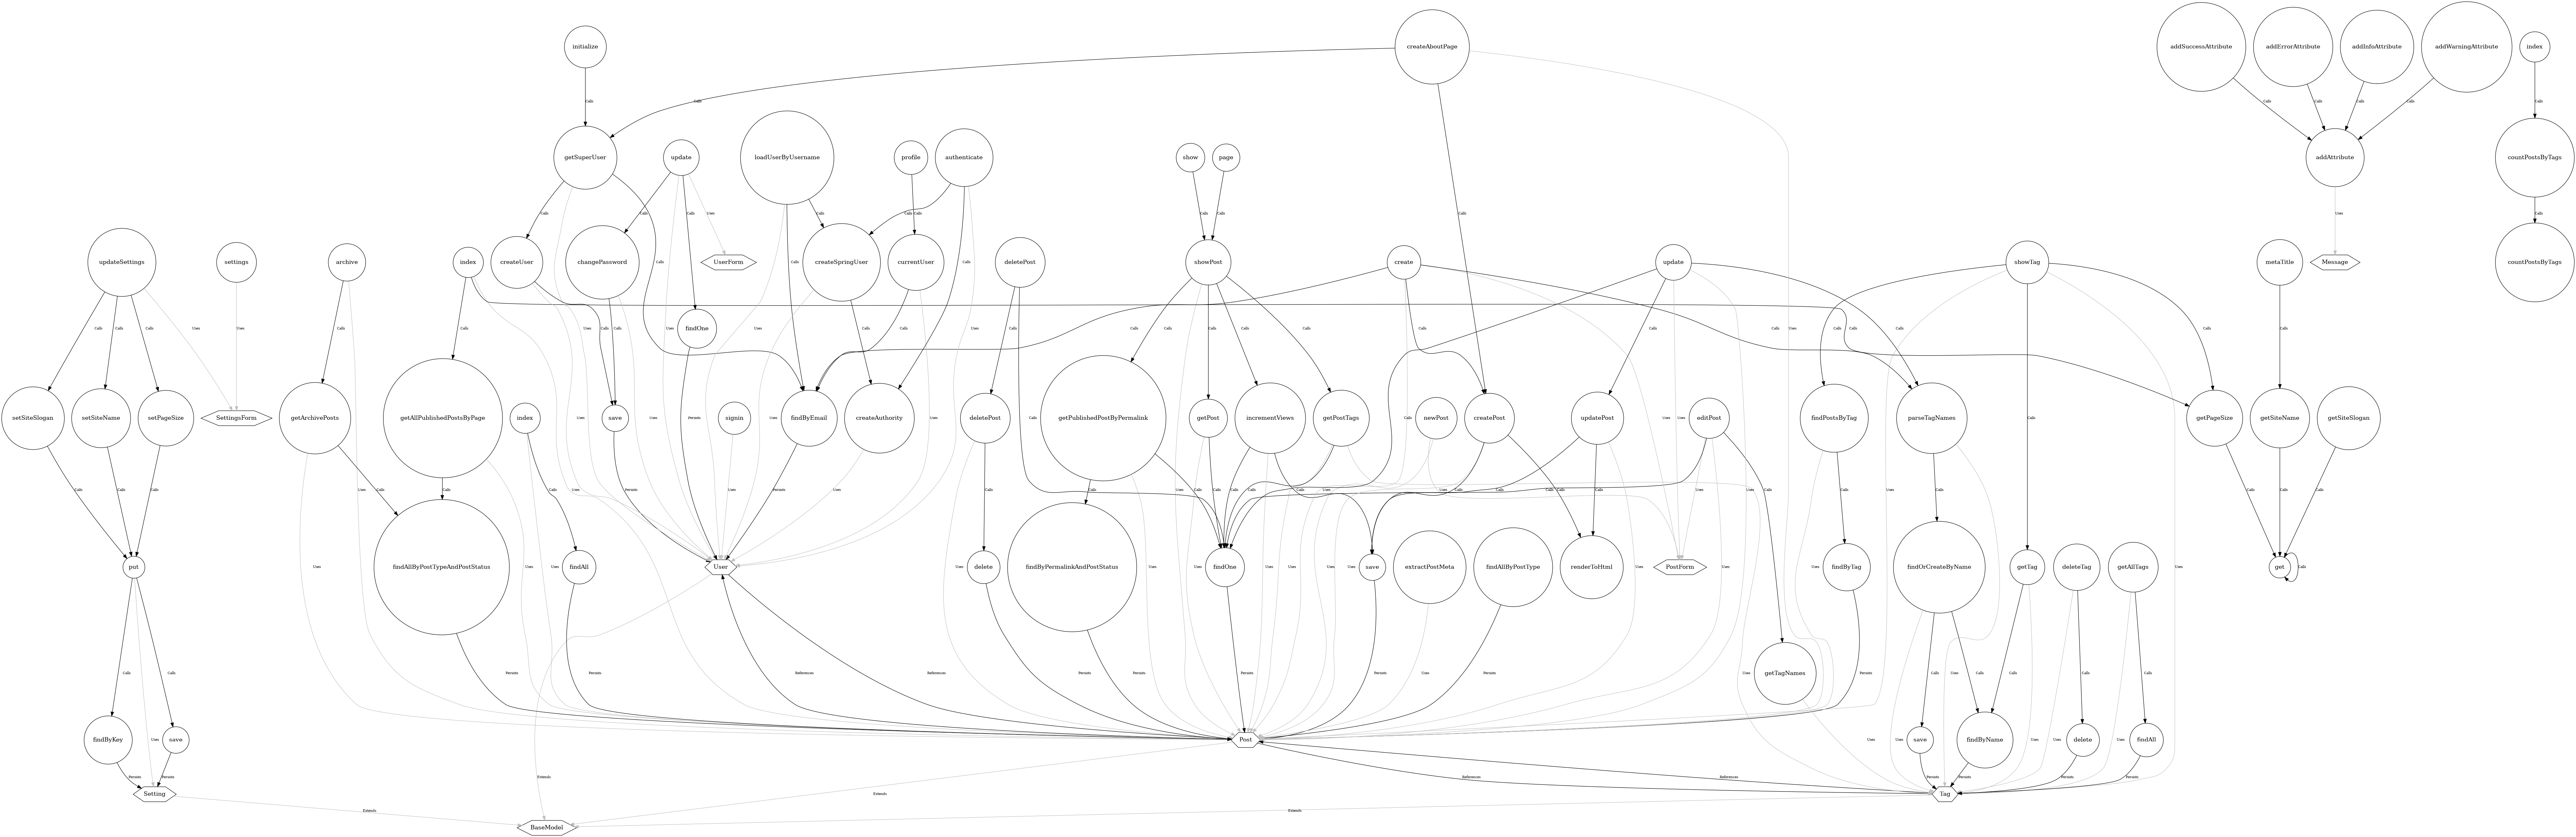

In [20]:
remove_isolated = True # <-- Set this variable!

if remove_isolated:
    if not nx.is_weakly_connected(G):
        isolating_nodes = list(nx.isolates(G))

        for node in isolating_nodes:
            if G.nodes[node]['type']=='Entity':
                print('Removed Entity ' + G.nodes[node]['name'])
            else:
                print('Removed ' + G.nodes[node]['name'] + ' (' + G.nodes[node]['class_name'] + ')')

        G.remove_nodes_from(isolating_nodes)

        DrawInitialGraph(G)
        display(Image(filename = analysis_results_basedir + project + '_graph.png'))
    else:
        print('The graph is connected') 

In [21]:
nx.write_graphml(G, analysis_results_basedir + project + '_graph.gml')